In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import math 
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from scipy import stats 
import plotly.express as px
from sklearn import preprocessing
from sklearn.linear_model import Lasso
import warnings

In [372]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')  

#Carga de datos

In [373]:
train_data_full = pd.read_csv('house_train_raw.csv')

#Dimension del Dataframe

In [374]:
train_data_full.shape

(1460, 81)

#Verifico la distribucion de la columna target 

In [375]:
train_data_full['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#No sigue una distribucion Normal. Lo cual es logico, los precios no pueden tomar valores negativos . Los precios siguen una distribucion Lognormal

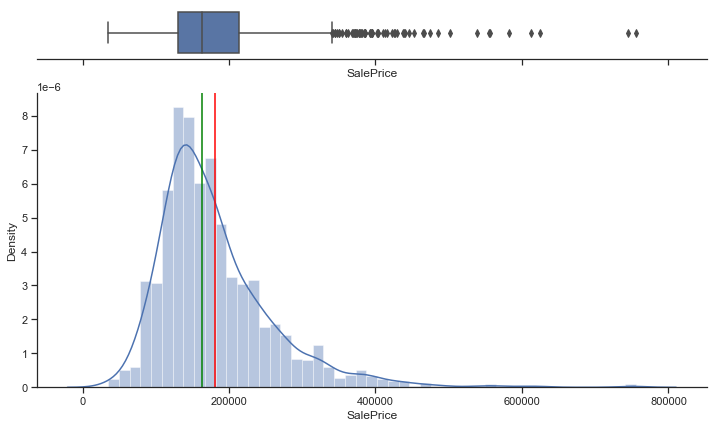

Skewness: 1.882876
Kurtosis: 6.536282


In [376]:
sns.set(style="ticks")
x = train_data_full['SalePrice']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12,7))

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)
plt.axvline(x = x.mean(), c = 'red')
plt.axvline(x = x.median(), c = 'green')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()
print("Skewness: %f" % train_data_full['SalePrice'].skew())
print("Kurtosis: %f" % train_data_full['SalePrice'].kurt())

#Aplico logaritmo para visualizar la distribucion como normal

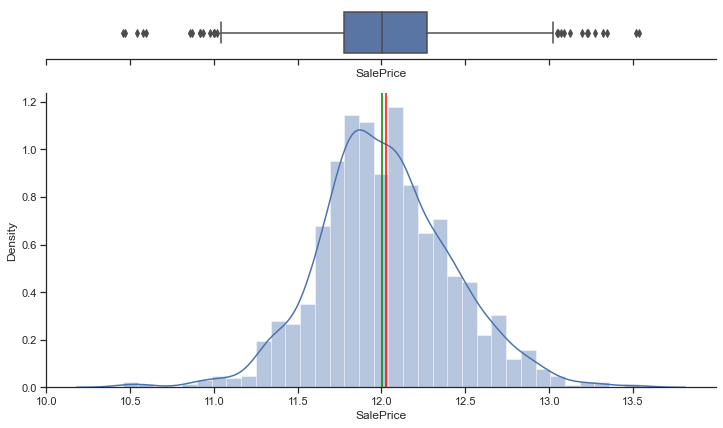

In [377]:
sns.set(style="ticks")

x = (np.log1p(train_data_full['SalePrice']))
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12,7))

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)
plt.axvline(x = x.mean(), c = 'red')
plt.axvline(x = x.median(), c = 'green')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()

#Listado de columnas

In [378]:
train_data_full.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [379]:
#elimino filas con precio nulos
train_data_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
train_data_full['SalePrice_log']=np.log1p(train_data_full['SalePrice'])

#Creo mi df con los features (sin columna target)
train_data = train_data_full.drop(['SalePrice'], axis=1)
train_data = train_data_full.drop(['SalePrice_log'], axis=1)
train_data = train_data_full.drop(['Id'], axis=1)


In [380]:
train_data_full = train_data_full.drop(['Id'], axis=1)

#Verificacion de datos faltantes

In [381]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479
GarageCond,81,0.055479


#Busco si hay columnas con datos faltantes

In [382]:
columns_with_null = train_data.count()[train_data.count()<0.80*max(train_data.count())].index.tolist()
print("columnas a eliminar: \n",columns_with_null)

columnas a eliminar: 
 ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [383]:
train_data.drop(columns_with_null, inplace= True, axis = 1)
train_data_full.drop(columns_with_null, inplace= True, axis = 1)

#Determino columnas categoricas

In [384]:
categorical_cols = {cname for cname in train_data.columns if train_data[cname].dtype == "object"}


#Determino columnas numericas

In [385]:
numerical_cols = {cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']}

In [386]:
print("columnas cuantitativas: " + str(len(categorical_cols)))
print("columnas cualitativas: " + str(len(numerical_cols)))

columnas cuantitativas: 38
columnas cualitativas: 38


In [387]:
train_data[numerical_cols].head(1)

,GrLivArea,KitchenAbvGr,BsmtFinSF2,ScreenPorch,MoSold,LotFrontage,OverallQual,OpenPorchSF,MasVnrArea,SalePrice,...,1stFlrSF,TotalBsmtSF,2ndFlrSF,LotArea,YearRemodAdd,WoodDeckSF,Fireplaces,LowQualFinSF,GarageYrBlt,BsmtUnfSF
0,1710,1,0,0,2,65.0,7,61,196.0,208500,...,856,856,854,8450,2003,0,0,0,2003.0,150


In [388]:
train_data[categorical_cols].head(1)

,MasVnrType,LandSlope,Functional,LandContour,BsmtFinType2,Exterior2nd,Heating,ExterQual,PavedDrive,Electrical,...,SaleType,Exterior1st,Condition2,CentralAir,KitchenQual,GarageFinish,BsmtExposure,GarageQual,MSZoning,Foundation
0,BrkFace,Gtl,Typ,Lvl,Unf,VinylSd,GasA,Gd,Y,SBrkr,...,WD,VinylSd,Norm,Y,Gd,RFn,No,TA,RL,PConc


#Verifico correlacion de las columnas

In [389]:
train_data_full.corr()['SalePrice'].sort_values(ascending=False).head(15)

SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
Name: SalePrice, dtype: float64

#correlaciones mayor a 0.50

<AxesSubplot:>

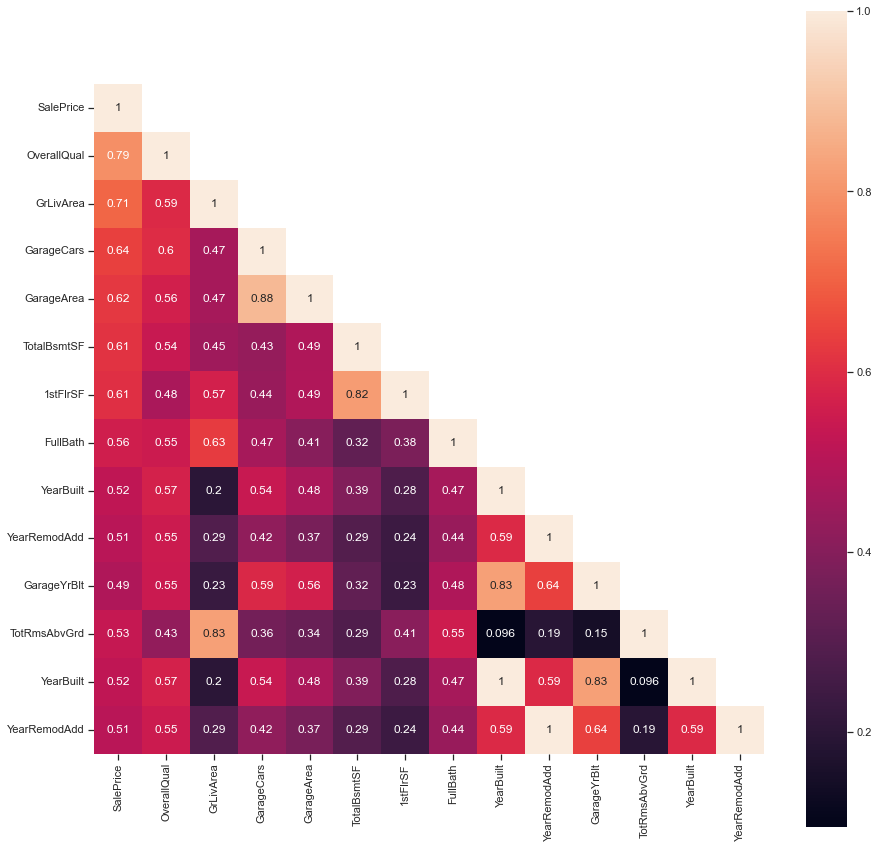

In [390]:
cor_mat= train_data_full[['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','YearRemodAdd','GarageYrBlt','TotRmsAbvGrd', 'YearBuilt','YearRemodAdd']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(15,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

#Visualizo graficamente

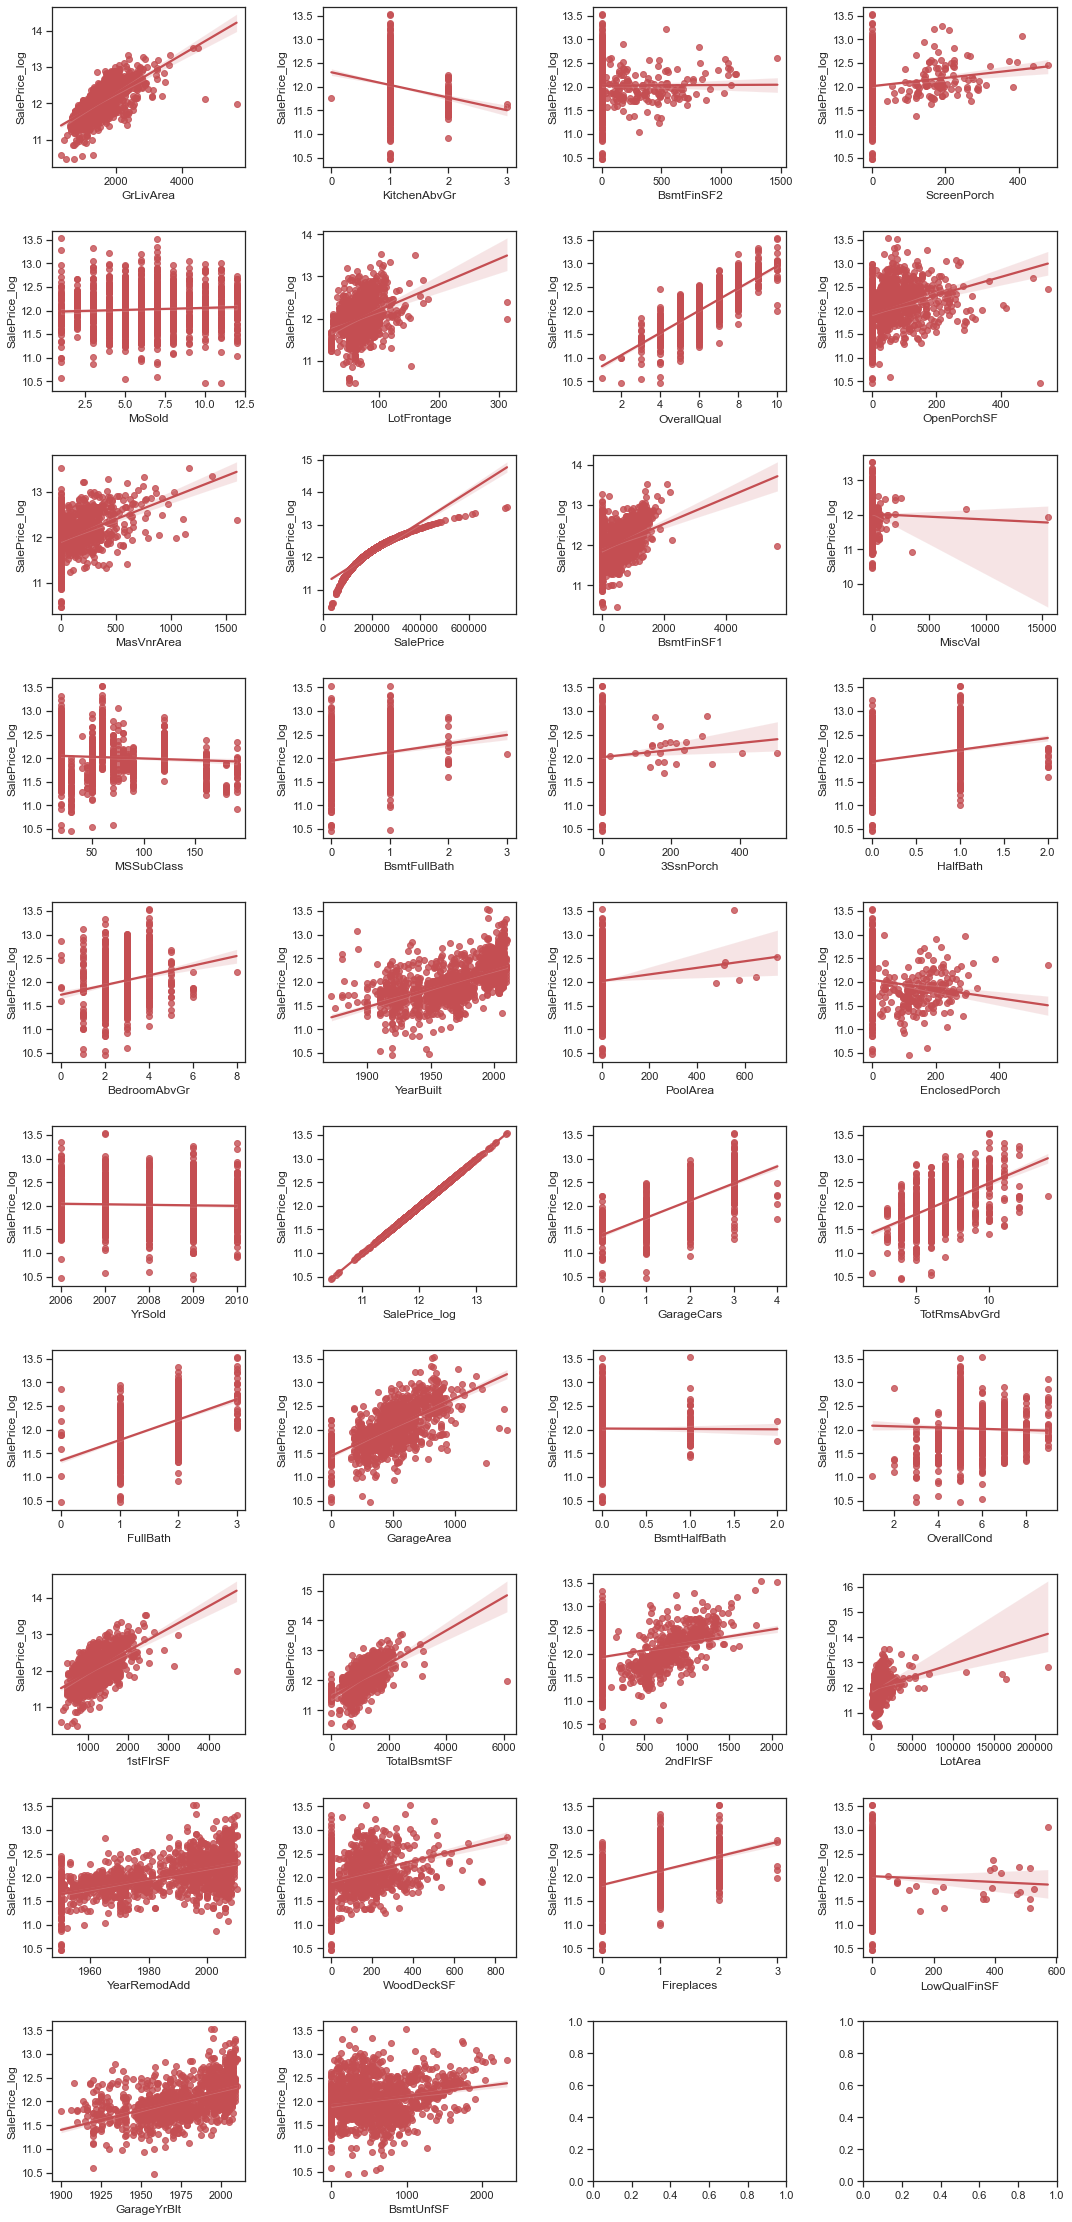

In [391]:
n=len(train_data[numerical_cols].columns) # number of plots
f, axes = plt.subplots(nrows=(n-1)//4 +1,ncols=4,squeeze=False,figsize=(18,4*((n-1)//4 +1))) # represent them on 4 columnms
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4) # increase space between plots

for col, ax in zip(numerical_cols, axes.flatten()[:n]):
    sns.regplot(data=train_data,x=col,y='SalePrice_log', ax=ax ,color='r')

plt.show()

#columnas con una relacion debil parecen ser: 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'

In [392]:
min_val_corr = 0.5  
corr = train_data_full.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_cols)
ser_corr = corr_abs.nlargest(nr_num_cols, 'SalePrice_log')['SalePrice_log']

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [393]:
print("Listado de columnas con correlacion alta:")
print(cols_abv_corr_limit)

Listado de columnas con correlacion alta:
['SalePrice_log', 'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'TotRmsAbvGrd']


In [394]:
print("Listado de columnas con correlacion baja :")
print(cols_bel_corr_limit)

Listado de columnas con correlacion baja :
['Fireplaces', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'MSSubClass', 'PoolArea', 'MoSold', '3SsnPorch', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']


#Analisis de las columnas con las que mayor correlacion hay: 

#OverallQual: Calificacion del material y acabado de la casa

In [395]:
fig = px.box(train_data_full, x="OverallQual", y="SalePrice")
fig.show()

#TotalBsmtSF: Tamaño del sotano

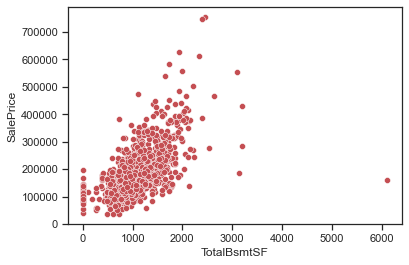

In [396]:
ax = sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=train_data_full, color='r')

#1stFlrSF: Pies cuadrados del primer piso

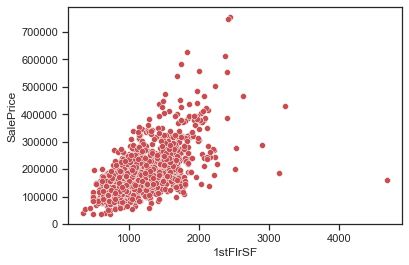

In [397]:
ax = sns.scatterplot(x="1stFlrSF", y="SalePrice", data=train_data_full, color='r')

#GrLivArea: Pies cuadrados del area principal


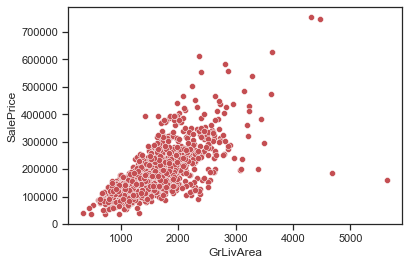

In [398]:
ax = sns.scatterplot(x="GrLivArea", y="SalePrice", data=train_data_full, color='r')

#GarageCars: Cantidad de autos que permite alojar el garage

In [399]:
fig = px.box(train_data_full, x="GarageCars", y="SalePrice")
fig.show()

#GarageArea: tamaño del garage

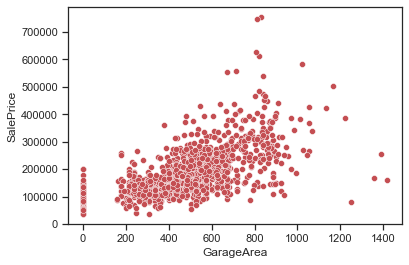

In [400]:
ax = sns.scatterplot(x="GarageArea", y="SalePrice", data=train_data_full, color='r')

#Se eliminan Outliers:

In [401]:
train_data = train_data.drop(train_data[(train_data['SalePrice']>740000)].index).reset_index(drop=True)

In [402]:
train_data = train_data.drop(train_data[(train_data['1stFlrSF']>3500)].index).reset_index(drop=True)

In [403]:
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4500)].index).reset_index(drop=True)

In [404]:
train_data = train_data.drop(train_data[(train_data['GarageCars']>3)].index).reset_index(drop=True)

In [405]:
train_data = train_data.drop(train_data[(train_data['GarageArea']>1240)].index).reset_index(drop=True)

#Relacion entre Precio y columnas categoricas

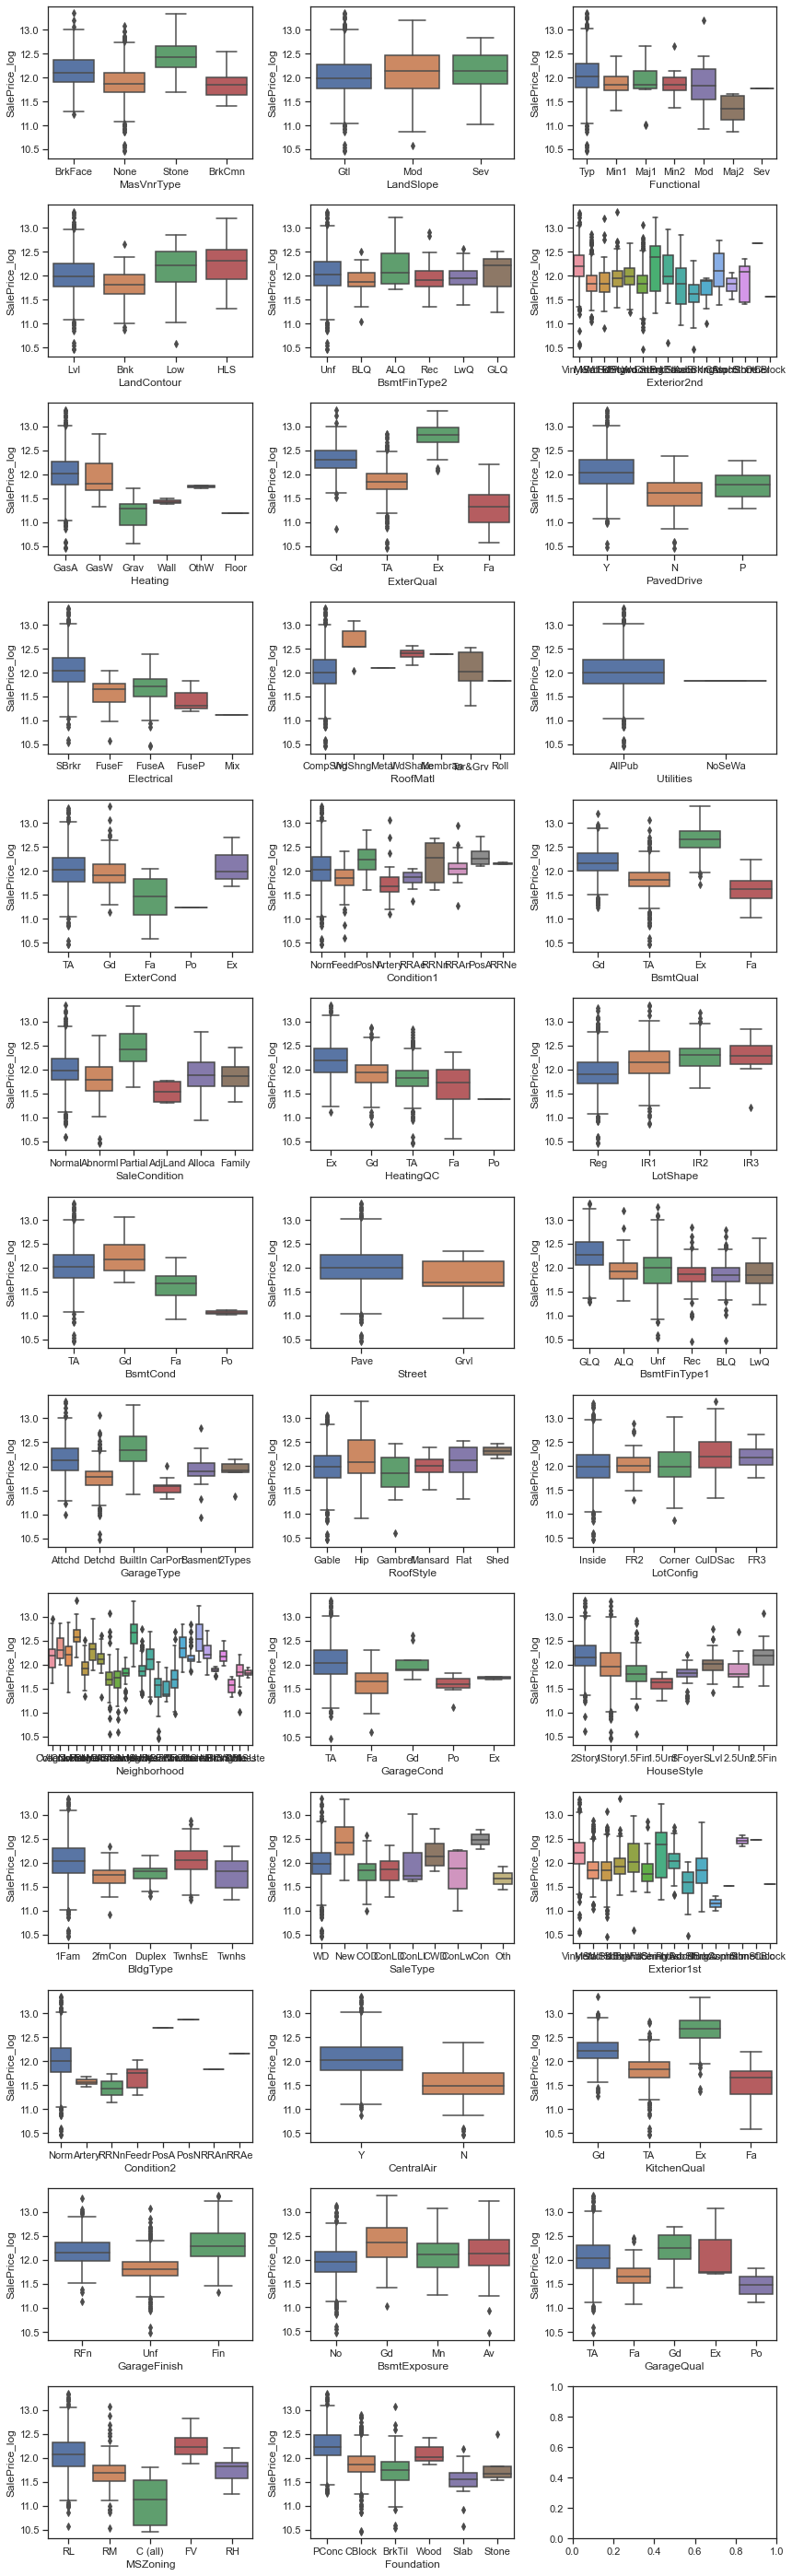

In [406]:
li_cat_feats = list(categorical_cols)
nr_rows = 13
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y='SalePrice_log', data=train_data, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

In [407]:
cat_fuerte = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

cat_Debil = ['Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 
                  'SaleCondition' ]

#Elimino columnas: categoricas y numericas con debil o negativa relacion

In [408]:
train_data.drop(cols_bel_corr_limit, inplace= True, axis = 1)
train_data.drop(cat_Debil, inplace= True, axis = 1)


#Codifico variables categoricas con buena correlacion

In [409]:
label_encoder=preprocessing.LabelEncoder ()
for column in train_data:
    if column in cat_fuerte:
        train_data[column] =label_encoder.fit_transform (train_data[column])

In [410]:
train_data.head(2)

,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,...,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SaleType,SalePrice,SalePrice_log
0,3,5,2,7,2003,2003,1,2,2,856,...,1710,2,2,8,2003.0,2,548,8,208500,12.247699
1,3,24,2,6,1976,1976,2,3,2,1262,...,1262,2,3,6,1976.0,2,460,8,181500,12.109016


#Verifico correlacion de variables categoricas con Precio

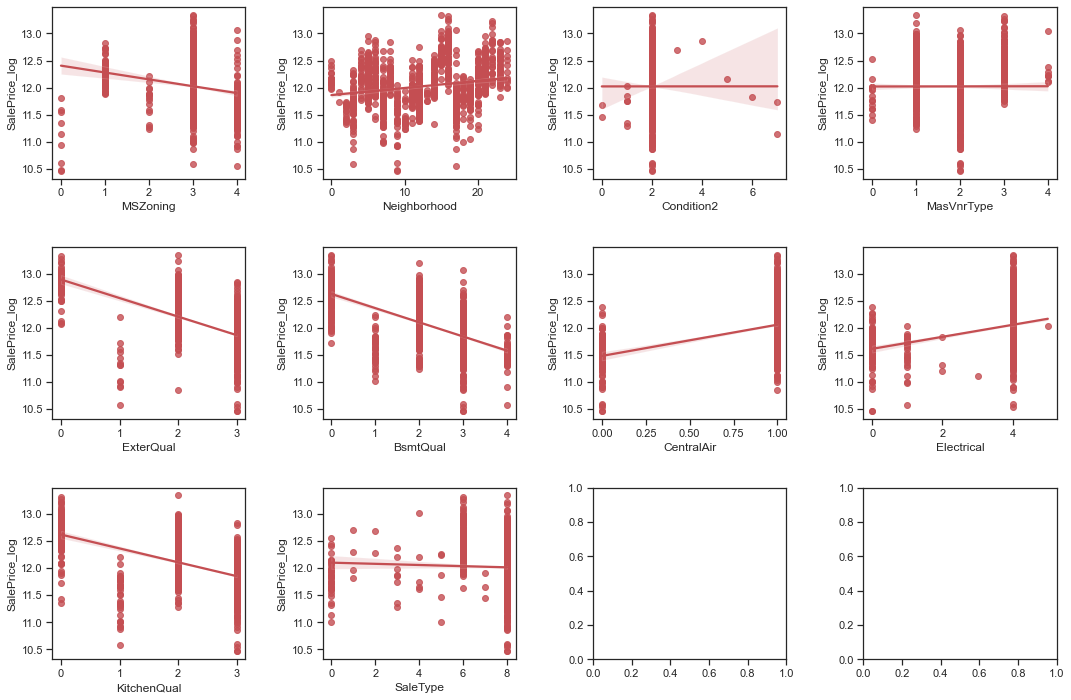

In [411]:
n=len(train_data[cat_fuerte].columns) # number of plots
f, axes = plt.subplots(nrows=(n-1)//4 +1,ncols=4,squeeze=False,figsize=(18,4*((n-1)//4 +1))) # represent them on 4 columnms
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4) # increase space between plots

for col, ax in zip(cat_fuerte, axes.flatten()[:n]):
    sns.regplot(data=train_data,x=col,y='SalePrice_log', ax=ax ,color='r')

plt.show()

In [412]:
corr1 = train_data.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(train_data)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, 'SalePrice_log')['SalePrice_log']

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)



SalePrice_log    1.000000
SalePrice        0.954570
OverallQual      0.819771
GrLivArea        0.718761
GarageCars       0.692023
GarageArea       0.669486
TotalBsmtSF      0.641420
1stFlrSF         0.613357
YearBuilt        0.592796
FullBath         0.591469
BsmtQual         0.589707
ExterQual        0.589443
YearRemodAdd     0.567623
GarageYrBlt      0.546999
TotRmsAbvGrd     0.533766
KitchenQual      0.530558
CentralAir       0.359555
Electrical       0.296225
MSZoning         0.200649
Neighborhood     0.200404
SaleType         0.042139
MasVnrType       0.001822
Condition2       0.000123
Name: SalePrice_log, dtype: float64


#Elimino columnas categoricas con baja correlacion

In [413]:
catg_drop = ['Neighborhood' , 'Condition2', 'MasVnrType','CentralAir', 'Electrical', 'SaleType','ExterQual','BsmtQual','KitchenQual']

In [414]:
train_data.drop(catg_drop, inplace= True, axis = 1)


In [415]:
train_data.columns

Index(['MSZoning', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'SalePrice', 'SalePrice_log'],
      dtype='object')

#Mapa de correlacion 

<AxesSubplot:>

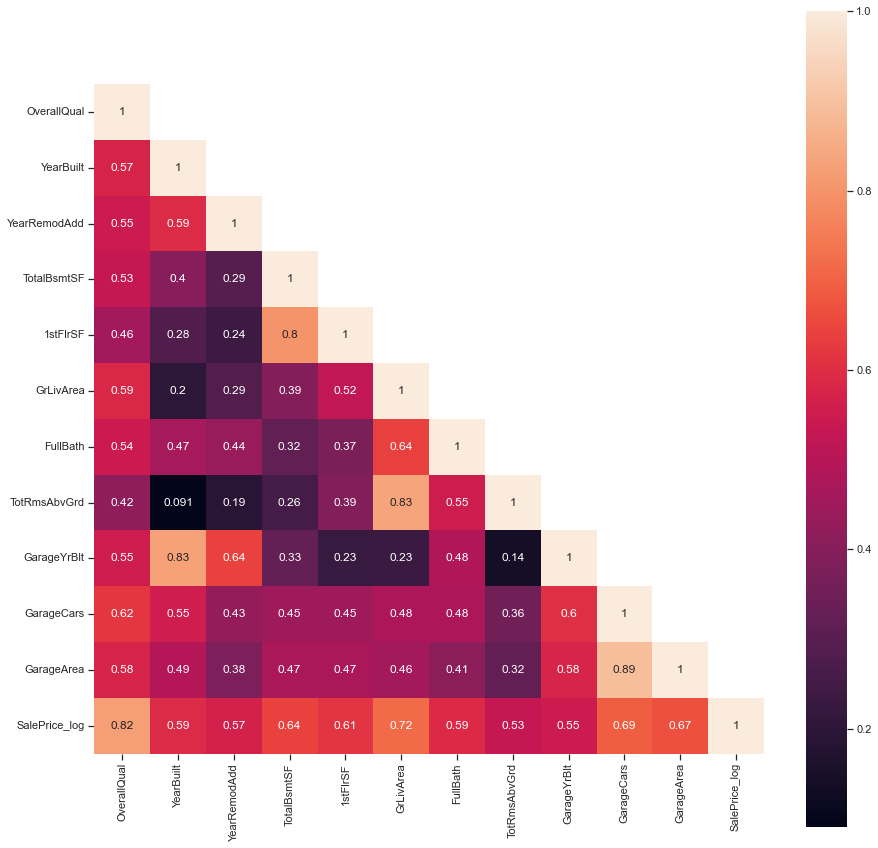

In [416]:
cor_mat= train_data[['OverallQual', 'YearBuilt', 'YearRemodAdd', 
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'SalePrice_log']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(15,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

##COLUMNAS A UTILIZAR

In [417]:
my_cols = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea']

In [418]:
def RMSLE_score_model(data,model):

    
    y=data['SalePrice_log']
    
    transformer = SimpleImputer(strategy='most_frequent')
    
    X=transformer.fit_transform(data[my_cols])
    
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
    
    
    model.fit(X_train, y_train)


    preds = model.predict(X_valid)
    
    return mean_squared_log_error(y_valid, preds, squared=False)

In [419]:
def RMSLE_CV_score_model(data,model):

    y=data['SalePrice_log']
    
    transformer = SimpleImputer(strategy='most_frequent')
    
    X=transformer.fit_transform(data[my_cols])
    
    scores = -1 * cross_val_score(model, X, y,
                              cv=5,
                              scoring='neg_mean_squared_log_error')
    
    scores=np.sqrt(scores)
    return scores.mean()

#Linear regression with cross validation - all features

In [420]:
model = LinearRegression()
RMSLE = RMSLE_CV_score_model(train_data,model)
print('RMSLE ='+ str(RMSLE))

RMSLE =0.011706029278421948


In [421]:
#RegresionLineal
RL=RMSLE_CV_score_model(train_data,model)

#Random Forest

In [422]:
for n_estimators in [50,100,500,1000,2000]:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=5, min_samples_split=4)
    RMSLE = RMSLE_score_model(train_data,model)
    print('RMSLE = %.10f for n_estimators = %d'%(RMSLE, n_estimators))
    

RMSLE = 0.0119603915 for n_estimators = 50
RMSLE = 0.0121724306 for n_estimators = 100
RMSLE = 0.0119146641 for n_estimators = 500
RMSLE = 0.0118023667 for n_estimators = 1000
RMSLE = 0.0118021287 for n_estimators = 2000


In [423]:
#Mejor Random Forest
model = RandomForestRegressor(n_estimators=500, random_state=5, min_samples_split=4)
RF = RMSLE_score_model(train_data,model)

#Lasso

In [424]:
for alpha in [0,0.002,0.1,0.2,0.5,0.8,1]:
    model = Lasso(random_state=0, alpha=alpha, max_iter=10000, normalize=False)
    MAE = RMSLE_score_model(train_data,model)
    print('RMSLE = %.10f for alpha = %f '%(MAE, alpha))

RMSLE = 0.0114701464 for alpha = 0.000000 
RMSLE = 0.0114854949 for alpha = 0.002000 
RMSLE = 0.0129374226 for alpha = 0.100000 
RMSLE = 0.0131745769 for alpha = 0.200000 
RMSLE = 0.0134414228 for alpha = 0.500000 
RMSLE = 0.0138163931 for alpha = 0.800000 
RMSLE = 0.0141221716 for alpha = 1.000000 


In [425]:
#Mejor Lasso
model = Lasso(random_state=0, alpha=0.0, max_iter=1000, normalize=False)
las = RMSLE_score_model(train_data,model)

#KNN Regressor

In [426]:

for n_neighbors in [3,4,5,6,7,10,15]:
    model = KNeighborsRegressor(n_neighbors=n_neighbors) 
    RMSLE = RMSLE_score_model(train_data,model)
    print('RMSLE = %.10f for n_neighbors = %d '%(RMSLE, n_neighbors))

RMSLE = 0.0164518164 for n_neighbors = 3 
RMSLE = 0.0165972172 for n_neighbors = 4 
RMSLE = 0.0163201392 for n_neighbors = 5 
RMSLE = 0.0162339673 for n_neighbors = 6 
RMSLE = 0.0161278802 for n_neighbors = 7 
RMSLE = 0.0163327064 for n_neighbors = 10 
RMSLE = 0.0160495954 for n_neighbors = 15 


In [427]:
#Mejor KNNR
model = KNeighborsRegressor(n_neighbors=3) 
KNNR = RMSLE_score_model(train_data,model)

#XGBOOST

In [428]:
for n_estimators in [10,50,100,500,1000,3500,5000]:
    model = XGBRegressor(learning_rate=0.01,n_estimators=n_estimators,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006) 
    RMSLE = RMSLE_score_model(train_data,model)
    print('RMSLE = %.10f for n_estimators = %d '%(RMSLE, n_estimators))

[11:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE = 1.6105824460 for n_estimators = 10 
[11:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE = 0.7671238038 for n_estimators = 50 
[11:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE = 0.3924559374 for n_estimators = 100 
[11:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE = 0.0130733316 for n_estimators = 500 
[11:16:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:2

In [429]:
#Mejor XGBRegressor
model = XGBRegressor(learning_rate=0.01,n_estimators=3500,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006) 
XGB = RMSLE_score_model(train_data,model)

[11:16:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


#Gradient boost

In [430]:
for n_estimators in [10,70,100,500,1000,3000]:
    learning_rate = 0.2
    model = GradientBoostingRegressor(random_state=0, n_estimators=n_estimators, learning_rate=learning_rate,max_depth=3) 
    RMSLE = RMSLE_score_model(train_data,model)
    print('RMSLE = %.10f for n_estimators = %d and learning_rate = %f'%(RMSLE, n_estimators, learning_rate))

RMSLE = 0.0130933051 for n_estimators = 10 and learning_rate = 0.200000
RMSLE = 0.0111888484 for n_estimators = 70 and learning_rate = 0.200000
RMSLE = 0.0112912111 for n_estimators = 100 and learning_rate = 0.200000
RMSLE = 0.0118440625 for n_estimators = 500 and learning_rate = 0.200000
RMSLE = 0.0121138112 for n_estimators = 1000 and learning_rate = 0.200000
RMSLE = 0.0122336789 for n_estimators = 3000 and learning_rate = 0.200000


In [431]:
#Mejor Gradient Boost
learning_rate = 0.2
model = GradientBoostingRegressor(random_state=0, n_estimators=70, learning_rate=learning_rate, max_depth=3) 
GB = RMSLE_score_model(train_data,model)


#RIDGE

In [432]:
for alpha in [0.001,0.005,0.01,0.1,0.5,1]:
    model = Ridge( alpha=alpha,random_state=0,normalize=False) 
    RMSLE = RMSLE_score_model(train_data,model)
    print('RMSLE = %.10f for alpha = %f '%(RMSLE, alpha))

RMSLE = 0.0114701465 for alpha = 0.001000 
RMSLE = 0.0114701471 for alpha = 0.005000 
RMSLE = 0.0114701478 for alpha = 0.010000 
RMSLE = 0.0114701601 for alpha = 0.100000 
RMSLE = 0.0114702161 for alpha = 0.500000 
RMSLE = 0.0114702883 for alpha = 1.000000 


In [433]:
#Mejor Ridge
modelRidge = Ridge( alpha=0.001,random_state=0,normalize=False) 
Ridg= RMSLE_score_model(train_data,modelRidge)


#Elastic Net

In [434]:
for alpha in [0.001,0.005,0.01,0.1,0.5,1]:
    model = ElasticNet( alpha=alpha,random_state=0, max_iter=10000, tol=1e-04,l1_ratio=0.04) 
    MAE = RMSLE_score_model(train_data,model)
    print('RMSLE = %.10f for alpha = %f '%(MAE, alpha))

RMSLE = 0.0114697851 for alpha = 0.001000 
RMSLE = 0.0114699575 for alpha = 0.005000 
RMSLE = 0.0114720649 for alpha = 0.010000 
RMSLE = 0.0115800335 for alpha = 0.100000 
RMSLE = 0.0120567123 for alpha = 0.500000 
RMSLE = 0.0125383103 for alpha = 1.000000 


In [435]:
#Mejor ElasticNet
model = ElasticNet( alpha=0.001000,random_state=0, max_iter=10000, tol=1e-04,l1_ratio=0.04) 
Elas = RMSLE_score_model(train_data,model)
 

#Decision Tree

In [436]:
for max_Depht in [4,5,7,8,9,10,15,20]:
    model = DecisionTreeRegressor(max_depth=max_Depht, random_state=5, max_features=12)
    RMSLE = RMSLE_score_model(train_data,model)
    print('RMSLE = %.10f for depht = %d'%(RMSLE, max_Depht))
    

RMSLE = 0.0155877083 for depht = 4
RMSLE = 0.0151855658 for depht = 5
RMSLE = 0.0167008700 for depht = 7
RMSLE = 0.0146838025 for depht = 8
RMSLE = 0.0165019881 for depht = 9
RMSLE = 0.0171421847 for depht = 10
RMSLE = 0.0158882945 for depht = 15
RMSLE = 0.0169565578 for depht = 20


In [437]:
#Mejor DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, random_state=5, max_features=10)
DTR= RMSLE_score_model(train_data,model)


#Comparo los resultados de los diferentes modelos

In [438]:
scores = [RL, RF, las, XGB, GB, Ridg, Elas, DTR]
modelos = ['Linear', 'RForest', 'Lasso', 'XGBOOST', 'GradientBoost', 'RIDGE', 'ElasticNet','DecisionTree']
metricas = {'modelos':modelos, 'scores':scores}
df_metricas = pd.DataFrame(metricas)

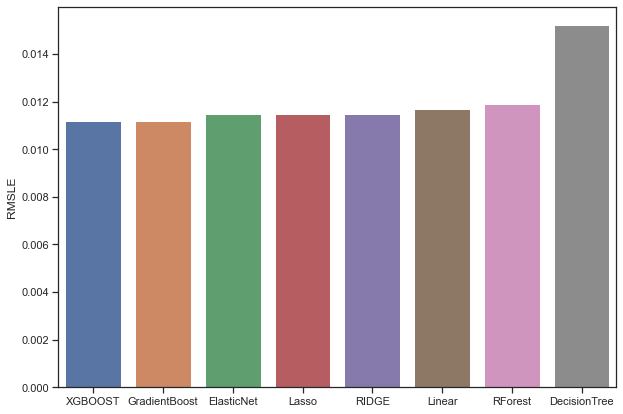

In [439]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=modelos, y=scores,data=df_metricas ,ax=ax, order=df_metricas.sort_values('scores').modelos)
plt.ylabel('RMSLE')
plt.show()

#Mejor Score XGBOOST

In [440]:
print('score: ' + str(XGB))

score: 0.011184670299281182


#Con el modelo elegido calculo prediccion y exporto a CSV

In [441]:
def model_to_csv(data,model,predecir):

    X=data[my_cols]
    
    y=np.log1p(data['SalePrice'])

    cat_cols = {cname for cname in X.columns if X[cname].dtype == "object"}
    label_encoder=preprocessing.LabelEncoder ()
    for column in X:
        if column in cat_cols:
            X[column] =label_encoder.fit_transform (X[column])
    
    
    transformer = SimpleImputer(strategy='most_frequent')
    
    X=transformer.fit_transform(X)

    
    model.fit(X, y)

    x_pred=predecir[my_cols]
    preds = model.predict(x_pred)
    
    preds= np.exp(preds) 

    df_pred=pd.DataFrame(preds)
    df_pred.to_csv('predicciones.csv')

In [442]:
test = pd.read_csv('houses_test_raw.csv')

In [443]:
modelXGB = XGBRegressor(learning_rate=0.01,n_estimators=1000,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006) 
XGB = RMSLE_score_model(train_data,model)
model_to_csv(train_data,modelXGB,test)

[11:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
